In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="wkfDNexv3HMFOEOdQwaK")
project = rf.workspace("jl-gk00z").project("vehicle-collision-lnd9k")
version = project.version(3)
dataset = version.download("yolov11")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle-Collision-3 in yolov11:: 100%|██████████| 4914/4914 [00:00<00:00, 7387.71it/s]


In [3]:
!pwd

/kaggle/working


In [4]:
!ls

Vehicle-Collision-3


In [5]:
!cat Vehicle-Collision-3/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['Truck', 'bus', 'cars', 'collision', 'motorcycle']

roboflow:
  workspace: jl-gk00z
  project: vehicle-collision-lnd9k
  version: 3
  license: CC BY 4.0
  url: https://universe.roboflow.com/jl-gk00z/vehicle-collision-lnd9k/dataset/3

In [6]:
# Path to the data.yaml file
yaml_path = '/kaggle/working/Vehicle-Collision-3/data.yaml'

# New YAML content
yaml_content = """
train: /kaggle/working/Vehicle-Collision-3/train_resized/images
val: /kaggle/working/Vehicle-Collision-3/valid_resized/images
test: /kaggle/working/Vehicle-Collision-3/test_resized/images

nc: 5
names: ['Bus', 'Truck', 'Motorcycle', 'Car', 'Collision']


"""

# Writing the new YAML content to the file
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print("data.yaml updated successfully!")


data.yaml updated successfully!


In [7]:
import os

# Define the old-to-new class ID mapping
class_mapping = {
    0: 1,  # 'Truck' -> 'Truck'
    1: 0,  # 'Bus' -> 'Bus'
    2: 3,  # 'Cars' -> 'Car'
    3: 4,  # 'Collision' -> 'Collision'
    4: 2   # 'Motorcycle' -> 'Motorcycle'
}

# Paths to your annotation folders
annotation_folders = [
    '/kaggle/working/Vehicle-Collision-3/valid/labels',
    '/kaggle/working/Vehicle-Collision-3/train/labels',
    '/kaggle/working/Vehicle-Collision-3/test/labels'
]

# Function to relabel YOLO annotations
def relabel_annotations(annotation_folders):
    for folder in annotation_folders:
        for filename in os.listdir(folder):
            if filename.endswith('.txt'):  # assuming YOLO annotations are in .txt files
                file_path = os.path.join(folder, filename)
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                
                # Relabel the class IDs in each line
                with open(file_path, 'w') as file:
                    for line in lines:
                        parts = line.strip().split()
                        class_id = int(parts[0])
                        if class_id in class_mapping:
                            # Replace old class_id with the new class_id
                            parts[0] = str(class_mapping[class_id])
                        file.write(' '.join(parts) + '\n')

        print(f"Annotations in {folder} relabeled successfully!")

# Run the relabeling function
relabel_annotations(annotation_folders)


Annotations in /kaggle/working/Vehicle-Collision-3/valid/labels relabeled successfully!
Annotations in /kaggle/working/Vehicle-Collision-3/train/labels relabeled successfully!
Annotations in /kaggle/working/Vehicle-Collision-3/test/labels relabeled successfully!


In [8]:
!pwd
!ls
!ls Vehicle-Collision-3
!mv Vehicle-Collision-3 vehiclecollision
!ls

/kaggle/working
Vehicle-Collision-3
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid
vehiclecollision


In [9]:
import cv2
import os
import glob
import numpy as np

# Paths to your dataset folders (images and labels)
folders = [
    {
        "image_folder": "vehiclecollision/train/images",
        "label_folder": "vehiclecollision/train/labels",
        "output_image_folder": "vehiclecollision/train_resized/images",
        "output_label_folder": "vehiclecollision/train_resized/labels"
    },
    {
        "image_folder": "vehiclecollision/valid/images",
        "label_folder": "vehiclecollision/valid/labels",
        "output_image_folder": "vehiclecollision/valid_resized/images",
        "output_label_folder": "vehiclecollision/valid_resized/labels"
    },
    {
        "image_folder": "vehiclecollision/test/images",
        "label_folder": "vehiclecollision/test/labels",
        "output_image_folder": "vehiclecollision/test_resized/images",
        "output_label_folder": "vehiclecollision/test_resized/labels"
    }
]

# Ensure output directories exist
for folder in folders:
    os.makedirs(folder["output_image_folder"], exist_ok=True)
    os.makedirs(folder["output_label_folder"], exist_ok=True)

# Target size
target_size = (416, 416)
original_size = (640, 640)

# Loop through each folder
for folder in folders:
    image_folder = folder["image_folder"]
    label_folder = folder["label_folder"]
    output_image_folder = folder["output_image_folder"]
    output_label_folder = folder["output_label_folder"]

    # Get all image files
    image_files = glob.glob(os.path.join(image_folder, "*.jpg"))  # Change to .png if needed

    for image_path in image_files:
        # Load image
        img = cv2.imread(image_path)
        img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)

        # Save resized image
        base_name = os.path.basename(image_path)
        new_image_path = os.path.join(output_image_folder, base_name)
        cv2.imwrite(new_image_path, img_resized)

        # Process label file (YOLO format)
        label_path = os.path.join(label_folder, base_name.replace(".jpg", ".txt"))
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
            
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                class_id = parts[0]
                x_center, y_center, width, height = map(float, parts[1:])
                
                # YOLO format is already normalized (0-1 range), so no need to change values.
                # If using Pascal VOC or COCO (absolute pixel values), scale them as below:
                # x_center = (x_center / original_width) * new_width
                # y_center = (y_center / original_height) * new_height
                # width = (width / original_width) * new_width
                # height = (height / original_height) * new_height

                new_lines.append(f"{class_id} {x_center} {y_center} {width} {height}\n")

            # Save updated labels
            new_label_path = os.path.join(output_label_folder, base_name.replace(".jpg", ".txt"))
            with open(new_label_path, "w") as f:
                f.writelines(new_lines)

    print(f"Dataset in {image_folder} resized successfully!")

print("All datasets resized successfully!")


Dataset in vehiclecollision/train/images resized successfully!
Dataset in vehiclecollision/valid/images resized successfully!
Dataset in vehiclecollision/test/images resized successfully!
All datasets resized successfully!


In [10]:
!ls vehiclecollision
!rm -rf vehiclecollision/README.dataset.txt vehiclecollision/README.roboflow.txt vehiclecollision/test vehiclecollision/train vehiclecollision/valid

data.yaml	     test	   train_resized
README.dataset.txt   test_resized  valid
README.roboflow.txt  train	   valid_resized


In [11]:
!ls vehiclecollision

data.yaml  test_resized  train_resized	valid_resized


In [12]:
!ls -l /kaggle/input/fastercnn/pytorch/default/1/fasterrcnn_model.pth

-rw-r--r-- 1 nobody nogroup 165770983 Jan 30 15:45 /kaggle/input/fastercnn/pytorch/default/1/fasterrcnn_model.pth


In [13]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, image_dir, label_dir, transforms=None):
#         self.image_dir = image_dir
#         self.label_dir = label_dir
#         self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
#         self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
#         self.transforms = transforms

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         try:
#             img_path = os.path.join(self.image_dir, self.image_files[idx])
#             label_path = os.path.join(self.label_dir, self.label_files[idx])
            
#             # Debugging print statements
#             print(f"Loading image from {img_path}")
#             print(f"Loading label from {label_path}")
            
#             img = Image.open(img_path).convert("RGB")
#             img_width, img_height = img.size
#             boxes = []
#             labels = []
            
#             with open(label_path, "r") as f:
#                 for line in f.readlines():
#                     data = list(map(float, line.strip().split()))
#                     labels.append(int(data[0]))  # Class label
#                     cx, cy, w, h = data[1:]  # Center coordinates and dimensions
#                     xmin = (cx - w / 2) * img_width
#                     ymin = (cy - h / 2) * img_height
#                     xmax = (cx + w / 2) * img_width
#                     ymax = (cy + h / 2) * img_height
#                     boxes.append([xmin, ymin, xmax, ymax])
            
#             if not boxes:
#                 print(f"No bounding boxes found for {img_path}")
            
#             boxes = torch.tensor(boxes, dtype=torch.float32)
#             labels = torch.tensor(labels, dtype=torch.int64)
            
#             # Skip samples without bounding boxes
#             if boxes.size(0) == 0:
#                 print(f"Skipping empty bounding box for {img_path}")
#                 return None  # Return None if no valid boxes

#             # Create target dictionary
#             target = {"boxes": boxes, "labels": labels}
            
#             # Apply transformations
#             if self.transforms:
#                 img = self.transforms(img)
            
#             return img, target

#         except Exception as e:
#             print(f"Error loading image {idx}: {e}")
#             return None


In [14]:
import torch
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
        self.transforms = transforms
        
        # Filter out images with no bounding boxes
        self.valid_samples = self._filter_valid_samples()

    def _filter_valid_samples(self):
        valid_samples = []
        for idx in range(len(self.image_files)):
            label_path = os.path.join(self.label_dir, self.label_files[idx])
            with open(label_path, "r") as f:
                label_lines = f.readlines()
                if label_lines:  # Only add image if there are bounding boxes
                    valid_samples.append(idx)
        return valid_samples

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        valid_idx = self.valid_samples[idx]
        img_path = os.path.join(self.image_dir, self.image_files[valid_idx])
        label_path = os.path.join(self.label_dir, self.label_files[valid_idx])

        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size
        boxes = []
        labels = []
        
        with open(label_path, "r") as f:
            label_lines = f.readlines()
            for line in label_lines:
                data = list(map(float, line.strip().split()))
                labels.append(int(data[0]))  # Class label
                cx, cy, w, h = data[1:]  # Center coordinates and dimensions
                xmin = (cx - w / 2) * img_width
                ymin = (cy - h / 2) * img_height
                xmax = (cx + w / 2) * img_width
                ymax = (cy + h / 2) * img_height
                boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Create target dictionary
        target = {"boxes": boxes, "labels": labels}
        
        # Apply transformations
        if self.transforms:
            img = self.transforms(img)
        
        return img, target


In [15]:
# Define transformations
import torchvision.transforms as T
import os

transform = T.Compose([
    T.ToTensor(),  # Convert image to PyTorch tensor
])

train_transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),  # Flip images horizontally 50% of the time
    T.RandomVerticalFlip(p=0.5),    # Flip images vertically 50% of the time
    T.RandomRotation(degrees=10),   # Randomly rotate images ±10 degrees
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust colors
    T.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Random crop
    T.ToTensor()
])

valid_transform = T.Compose([
    T.Resize((224, 224)),  # Keep validation images consistent
    T.ToTensor()
])



train_dataset = CustomDataset(
    image_dir="vehiclecollision/train_resized/images",
    label_dir="vehiclecollision/train_resized/labels",
    transforms=train_transform
)

valid_dataset = CustomDataset(
    image_dir="vehiclecollision/valid_resized/images",
    label_dir="vehiclecollision/valid_resized/labels",
    transforms=valid_transform
)

test_dataset = CustomDataset(
    image_dir="vehiclecollision/test_resized/images",
    label_dir="vehiclecollision/test_resized/labels",
    transforms=transform
)


In [16]:
print(train_dataset[0])  # Print first item from the dataset


(tensor([[[0.4196, 0.4196, 0.4235,  ..., 0.5098, 0.5137, 0.5137],
         [0.4157, 0.4196, 0.4235,  ..., 0.5137, 0.5137, 0.5137],
         [0.4157, 0.4157, 0.4275,  ..., 0.5255, 0.5255, 0.5255],
         ...,
         [0.3176, 0.3176, 0.3255,  ..., 0.4902, 0.4902, 0.4902],
         [0.3137, 0.3137, 0.3216,  ..., 0.4863, 0.4863, 0.4863],
         [0.3137, 0.3137, 0.3176,  ..., 0.4824, 0.4824, 0.4824]],

        [[0.5647, 0.5647, 0.5686,  ..., 0.6706, 0.6745, 0.6745],
         [0.5608, 0.5647, 0.5686,  ..., 0.6745, 0.6745, 0.6745],
         [0.5608, 0.5608, 0.5725,  ..., 0.6745, 0.6745, 0.6745],
         ...,
         [0.3608, 0.3608, 0.3686,  ..., 0.5098, 0.5098, 0.5098],
         [0.3569, 0.3569, 0.3647,  ..., 0.5059, 0.5059, 0.5059],
         [0.3569, 0.3569, 0.3608,  ..., 0.5020, 0.5020, 0.5020]],

        [[0.6353, 0.6353, 0.6392,  ..., 0.7412, 0.7451, 0.7451],
         [0.6314, 0.6353, 0.6392,  ..., 0.7451, 0.7451, 0.7451],
         [0.6314, 0.6314, 0.6431,  ..., 0.7569, 0.7569, 0

In [17]:
!cat vehiclecollision/train_resized/labels/-_-Cyberabad-Traffic-Police_mp4-0000_jpg.rf.29e987d548e8549068b2351700b08ad7.txt

In [18]:
# print(f"Number of test samples: {len(test_dataset)}")
# # Get a sample from the test dataset
# img, target = test_dataset[0]

# # Check image and target content
# print(f"Image shape: {img.shape}")
# print(f"Target (boxes and labels): {target}")
# # Inspect transformed image and label (first sample)
# img, target = test_dataset[0]
# print(f"Transformed image shape: {img.shape}")  # Should be a tensor of shape [C, H, W]


In [19]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # Fetch an image and its bounding boxes
# img, target = test_dataset[0]

# # Convert the tensor back to PIL image for visualization
# img_pil = T.ToPILImage()(img)

# # Plot the image
# fig, ax = plt.subplots(1)
# ax.imshow(img_pil)

# # Plot the bounding boxes
# for box in target["boxes"]:
#     xmin, ymin, xmax, ymax = box
#     rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
#                              linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

# plt.show()


In [20]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch import nn

# Define the number of classes (4 original + 1 new class = 5)
num_classes = 5  # Background + car, truck, bike, bus, collision

# Load the pre-trained Faster R-CNN model (without loading weights)
model = fasterrcnn_resnet50_fpn(pretrained=False)  

# Load the state dictionary (checkpoint)
model_path = "/kaggle/input/fastercnn/pytorch/default/1/fasterrcnn_model.pth"
state_dict = torch.load(model_path, weights_only=True)

# Remove the old classifier weights from the state_dict to avoid size mismatch
del state_dict["roi_heads.box_predictor.cls_score.weight"]
del state_dict["roi_heads.box_predictor.cls_score.bias"]
del state_dict["roi_heads.box_predictor.bbox_pred.weight"]
del state_dict["roi_heads.box_predictor.bbox_pred.bias"]

# Load the modified state dictionary (excluding the old classifier)
model.load_state_dict(state_dict, strict=False)

# Modify the classifier to handle 5 classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

print("Model loaded successfully with updated classifier.")


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s] 


Model loaded successfully with updated classifier.


In [21]:
# Verify that model is correctly modified
print("Modified classifier output shape:")
print("  Classifier weights shape (cls_score):", model.roi_heads.box_predictor.cls_score.weight.shape)
print("  Classifier bias shape (cls_score):", model.roi_heads.box_predictor.cls_score.bias.shape)
print("  BBox predictor weight shape:", model.roi_heads.box_predictor.bbox_pred.weight.shape)
print("  BBox predictor bias shape:", model.roi_heads.box_predictor.bbox_pred.bias.shape)

# Check if model layers (except classifier) loaded correctly
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel parameter details:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


Modified classifier output shape:
  Classifier weights shape (cls_score): torch.Size([5, 1024])
  Classifier bias shape (cls_score): torch.Size([5])
  BBox predictor weight shape: torch.Size([20, 1024])
  BBox predictor bias shape: torch.Size([20])

Model parameter details:
  Total parameters: 41,314,536
  Trainable parameters: 41,092,136


In [22]:
print(train_dataset)
print(valid_dataset)


In [23]:
print(train_dataset[0])


(tensor([[[0.4196, 0.4196, 0.4235,  ..., 0.5098, 0.5137, 0.5137],
         [0.4157, 0.4196, 0.4235,  ..., 0.5137, 0.5137, 0.5137],
         [0.4157, 0.4157, 0.4275,  ..., 0.5255, 0.5255, 0.5255],
         ...,
         [0.3176, 0.3176, 0.3255,  ..., 0.4902, 0.4902, 0.4902],
         [0.3137, 0.3137, 0.3216,  ..., 0.4863, 0.4863, 0.4863],
         [0.3137, 0.3137, 0.3176,  ..., 0.4824, 0.4824, 0.4824]],

        [[0.5647, 0.5647, 0.5686,  ..., 0.6706, 0.6745, 0.6745],
         [0.5608, 0.5647, 0.5686,  ..., 0.6745, 0.6745, 0.6745],
         [0.5608, 0.5608, 0.5725,  ..., 0.6745, 0.6745, 0.6745],
         ...,
         [0.3608, 0.3608, 0.3686,  ..., 0.5098, 0.5098, 0.5098],
         [0.3569, 0.3569, 0.3647,  ..., 0.5059, 0.5059, 0.5059],
         [0.3569, 0.3569, 0.3608,  ..., 0.5020, 0.5020, 0.5020]],

        [[0.6353, 0.6353, 0.6392,  ..., 0.7412, 0.7451, 0.7451],
         [0.6314, 0.6353, 0.6392,  ..., 0.7451, 0.7451, 0.7451],
         [0.6314, 0.6314, 0.6431,  ..., 0.7569, 0.7569, 0

In [24]:
# import torch
# import torchvision
# from torch.utils.data import DataLoader
# from torchvision.models.detection import FasterRCNN
# import torchvision.transforms as T
# import time

# # Define training hyperparameters
# BATCH_SIZE = 16
# LEARNING_RATE = 0.005
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def train_and_evaluate(model, train_dataset, valid_dataset, epochs, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE):
#     # DataLoader setup
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: list(zip(*x)))
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: list(zip(*x)))
    
#     # Move model to device
#     model.to(DEVICE)
    
#     # Define optimizer and learning rate scheduler
#     params = [p for p in model.parameters() if p.requires_grad]
#     optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#     # Training loop
#     for epoch in range(epochs):
#         print(f"\nEpoch [{epoch+1}/{epochs}]")
#         model.train()  # Set model to training mode
#         train_loss = 0.0
#         start_time = time.time()

#         for batch_idx, (images, targets) in enumerate(train_loader):
#             images = [img.to(DEVICE) for img in images]
#             targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

#             optimizer.zero_grad()

#             # Forward pass
#             loss_dict = model(images, targets)

#             # Check if the loss_dict is a list or a dictionary
#             total_loss = 0.0
#             if isinstance(loss_dict, list):
#                 for loss_entry in loss_dict:
#                     for loss_name, loss in loss_entry.items():
#                         total_loss += loss  # Accumulate losses
#             elif isinstance(loss_dict, dict):
#                 for loss_name, loss in loss_dict.items():
#                     total_loss += loss  # Accumulate losses
#             else:
#                 raise ValueError(f"Unexpected loss format: {type(loss_dict)}")

#             # Backward pass and optimization step
#             total_loss.backward()
#             optimizer.step()

#             train_loss += total_loss.item()

#             if (batch_idx % 10) == 0:
#                 # Print loss after every 10 batch
#                 print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {total_loss.item():.4f}")

#         # Update learning rate
#         lr_scheduler.step()

#         # Validation phase
#         model.eval()
#         valid_loss = 0.0
#         with torch.no_grad():
#             for batch_idx, (images, targets) in enumerate(valid_loader):
#                 images = [img.to(DEVICE) for img in images]
#                 targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
#                 loss_dict = model(images, targets)

#                 total_loss = 0.0
#                 if isinstance(loss_dict, list):
#                     for loss_entry in loss_dict:
#                         for loss_name, loss in loss_entry.items():
#                             total_loss += loss  # Accumulate losses
#                 elif isinstance(loss_dict, dict):
#                     for loss_name, loss in loss_dict.items():
#                         total_loss += loss  # Accumulate losses
#                 else:
#                     raise ValueError(f"Unexpected loss format: {type(loss_dict)}")

#                 valid_loss += total_loss.item()

#         # Print epoch stats
#         avg_train_loss = train_loss / len(train_loader)
#         avg_valid_loss = valid_loss / len(valid_loader)
#         epoch_time = time.time() - start_time

#         print(f"Epoch [{epoch+1}/{epochs}] Summary:")
#         print(f"  Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Time: {epoch_time:.2f}s")

#         # Save checkpoint after every epoch with dynamic naming
#         checkpoint_filename = f"fasterrcnn_finetuned_epoch{epoch+1}.pth"
#         torch.save(model.state_dict(), checkpoint_filename)
#         print(f"Model saved as {checkpoint_filename}")

#     print("Training complete!")

# # Example usage (assuming you have the model, train_dataset, and valid_dataset defined)
# # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# # train_and_evaluate(model, train_dataset, valid_dataset, epochs=5)


In [25]:
# import torch
# import torchvision
# from torch.utils.data import DataLoader
# from torchvision.models.detection import FasterRCNN
# import torchvision.transforms as T
# import time

# # Define training hyperparameters
# BATCH_SIZE = 16
# LEARNING_RATE = 0.005
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def calculate_total_loss(loss_dict):
#     """Helper function to calculate total loss regardless of format"""
#     if isinstance(loss_dict, dict):
#         # If it's a dictionary, take the mean of each loss
#         return sum(loss.mean() for loss in loss_dict.values())
#     elif isinstance(loss_dict, list):
#         total_loss = 0.0
#         for loss_entry in loss_dict:
#             if isinstance(loss_entry, dict):
#                 # If it's a dictionary within the list, take the mean of each loss
#                 total_loss += sum(loss.mean() for loss in loss_entry.values())
#             else:
#                 # If it's a direct tensor, take its mean
#                 total_loss += loss_entry.mean()
#         return total_loss
#     else:
#         # If it's a single tensor, take its mean
#         return loss_dict.mean()

# def train_and_evaluate(model, train_dataset, valid_dataset, epochs, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE):
#     # DataLoader setup
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=True, 
#         collate_fn=lambda x: tuple(zip(*x)),
#         drop_last=True
#     )
#     valid_loader = DataLoader(
#         valid_dataset, 
#         batch_size=batch_size, 
#         shuffle=False, 
#         collate_fn=lambda x: tuple(zip(*x)),
#         drop_last=True
#     )
    
#     # Move model to device
#     model.to(DEVICE)
    
#     # Define optimizer and learning rate scheduler
#     params = [p for p in model.parameters() if p.requires_grad]
#     optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#     # Training loop
#     for epoch in range(epochs):
#         print(f"\nEpoch [{epoch+1}/{epochs}]")
#         model.train()
#         train_loss = 0.0
#         start_time = time.time()

#         for batch_idx, (images, targets) in enumerate(train_loader):
#             try:
#                 images = list(image.to(DEVICE) for image in images)
#                 targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

#                 optimizer.zero_grad()

#                 # Forward pass and compute loss
#                 loss_dict = model(images, targets)
                
#                 # Calculate total loss using helper function
#                 total_loss = calculate_total_loss(loss_dict)

#                 # Backward pass and optimization
#                 total_loss.backward()
#                 optimizer.step()

#                 train_loss += total_loss.item()

#                 if (batch_idx % 10) == 0:
#                     print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {total_loss.item():.4f}")
                    
#             except RuntimeError as e:
#                 print(f"Error in batch {batch_idx}: {str(e)}")
#                 print("Skipping problematic batch...")
#                 continue

#         # Update learning rate
#         lr_scheduler.step()

#         # Validation phase
#         model.eval()
#         valid_loss = 0.0
#         valid_batches = 0
        
#         with torch.no_grad():
#             for batch_idx, (images, targets) in enumerate(valid_loader):
#                 try:
#                     images = list(image.to(DEVICE) for image in images)
#                     targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
                    
#                     # Forward pass
#                     loss_dict = model(images, targets)
                    
#                     # Calculate total loss using helper function
#                     total_loss = calculate_total_loss(loss_dict)
#                     valid_loss += total_loss.item()
#                     valid_batches += 1
                    
#                 except RuntimeError as e:
#                     print(f"Error in validation batch {batch_idx}: {str(e)}")
#                     print("Skipping problematic batch...")
#                     continue

#         # Print epoch stats
#         avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
#         avg_valid_loss = valid_loss / valid_batches if valid_batches > 0 else float('inf')
#         epoch_time = time.time() - start_time

#         print(f"Epoch [{epoch+1}/{epochs}] Summary:")
#         print(f"  Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Time: {epoch_time:.2f}s")

#         # Save checkpoint
#         checkpoint_filename = f"fasterrcnn_finetuned_epoch{epoch+1}.pth"
#         torch.save(model.state_dict(), checkpoint_filename)
#         print(f"Model saved as {checkpoint_filename}")

#     print("Training complete!")

In [ ]:
def calculate_total_loss(loss_dict):
    """Helper function to calculate total loss regardless of format"""
    if isinstance(loss_dict, dict):
        # Convert any integer tensors to float and take mean
        return sum(loss.float().mean() if loss.dtype == torch.long else loss.mean() 
                  for loss in loss_dict.values())
    elif isinstance(loss_dict, list):
        total_loss = 0.0
        for loss_entry in loss_dict:
            if isinstance(loss_entry, dict):
                # Convert any integer tensors to float and take mean
                total_loss += sum(loss.float().mean() if loss.dtype == torch.long else loss.mean() 
                                for loss in loss_entry.values())
            else:
                # Convert if integer tensor
                total_loss += loss_entry.float().mean() if loss_entry.dtype == torch.long else loss_entry.mean()
        return total_loss
    else:
        # Convert if integer tensor
        return loss_dict.float().mean() if loss_dict.dtype == torch.long else loss_dict.mean()


In [ ]:
def process_batch(batch, device):
    """Helper function to process batch data consistently"""
    images, targets = batch
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v
                for k, v in t.items()} for t in targets]
    
    # Ensure labels are int64 while keeping boxes as float
    for t in targets:
        if 'labels' in t:
            t['labels'] = t['labels'].long()  # Convert to int64
        if 'boxes' in t:
            t['boxes'] = t['boxes'].float()   # Ensure boxes are float
    
    return images, targets


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
import torchvision.transforms as T
import time
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

# Define training hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 0.005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER = GradScaler()  # Mixed Precision Training (AMP) Scaler

# ---- (1) Compute Class Weights for Imbalance Handling ----
def compute_class_weights(dataset, num_classes):
    """Calculate class weights based on dataset label distribution."""
    label_counts = Counter()
    
    for _, targets in dataset:
        for t in targets:
            label_counts.update(t["labels"].tolist())

    # Convert counts to weights (inverse frequency)
    total_samples = sum(label_counts.values())
    class_weights = {cls: total_samples / count for cls, count in label_counts.items()}
    
    # Normalize weights (optional)
    max_weight = max(class_weights.values())
    class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}
    
    # Convert to tensor
    weights = torch.zeros(num_classes, dtype=torch.float32)
    for cls, weight in class_weights.items():
        weights[cls] = weight

    return weights.to(DEVICE)

# Assume 5 classes (adjust accordingly)
NUM_CLASSES = 5
CLASS_WEIGHTS = compute_class_weights(train_dataset, NUM_CLASSES)

# ---- (2) Update Training Loop with AMP & Class Weights ----
def train_and_evaluate(model, train_dataset, valid_dataset, epochs, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE):
    # DataLoader setup
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=lambda x: tuple(zip(*x)),
        drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda x: tuple(zip(*x)),
        drop_last=True
    )

    # Move model to device
    model.to(DEVICE)

    # Define optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for batch_idx, batch in enumerate(train_loader):
            try:
                images, targets = process_batch(batch, DEVICE)
                optimizer.zero_grad()

                with autocast():  # Mixed Precision Training (AMP)
                    loss_dict = model(images, targets)

                    # Apply class weights to loss
                    total_loss = calculate_total_loss(loss_dict)
                    if "labels" in targets[0]:
                        labels = torch.cat([t["labels"] for t in targets])
                        class_weighted_loss = total_loss * CLASS_WEIGHTS[labels].mean()
                    else:
                        class_weighted_loss = total_loss

                SCALER.scale(class_weighted_loss).backward()  # AMP Scaling
                SCALER.step(optimizer)
                SCALER.update()

                train_loss += class_weighted_loss.item()

                if (batch_idx % 10) == 0:
                    print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {class_weighted_loss.item():.4f}")

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        lr_scheduler.step()  # Update learning rate

        # Validation Phase
        model.eval()
        valid_loss = 0.0
        valid_batches = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_loader):
                try:
                    images, targets = process_batch(batch, DEVICE)

                    with autocast():  # Mixed Precision for Validation
                        loss_dict = model(images, targets)
                        total_loss = calculate_total_loss(loss_dict)

                    valid_loss += total_loss.item()
                    valid_batches += 1

                except RuntimeError as e:
                    print(f"Error in validation batch {batch_idx}: {str(e)}")
                    continue

        # Print epoch stats
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
        avg_valid_loss = valid_loss / valid_batches if valid_batches > 0 else float('inf')
        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{epochs}] Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Time: {epoch_time:.2f}s")

        # Save checkpoint
        checkpoint_filename = f"fasterrcnn_finetuned_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_filename)
        print(f"Model saved as {checkpoint_filename}")

    print("Training complete!")


In [26]:
# import torch
# import torchvision
# from torch.utils.data import DataLoader
# from torchvision.models.detection import FasterRCNN
# import torchvision.transforms as T
# import time

# # Define training hyperparameters
# BATCH_SIZE = 8
# LEARNING_RATE = 0.005
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# def train_and_evaluate(model, train_dataset, valid_dataset, epochs, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE):
#     # DataLoader setup
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=True, 
#         collate_fn=lambda x: tuple(zip(*x)),
#         drop_last=True
#     )
#     valid_loader = DataLoader(
#         valid_dataset, 
#         batch_size=batch_size, 
#         shuffle=False, 
#         collate_fn=lambda x: tuple(zip(*x)),
#         drop_last=True
#     )
    
#     # Move model to device
#     model.to(DEVICE)
    
#     # Define optimizer and learning rate scheduler
#     params = [p for p in model.parameters() if p.requires_grad]
#     # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
#     # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#     optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
#     lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

#     # Training loop
#     for epoch in range(epochs):
#         print(f"\nEpoch [{epoch+1}/{epochs}]")
#         model.train()
#         train_loss = 0.0
#         start_time = time.time()

#         for batch_idx, batch in enumerate(train_loader):
#             try:
#                 images, targets = process_batch(batch, DEVICE)
#                 optimizer.zero_grad()

#                 # Forward pass and compute loss
#                 loss_dict = model(images, targets)
                
#                 # Calculate total loss using helper function
#                 total_loss = calculate_total_loss(loss_dict)

#                 # Backward pass and optimization
#                 total_loss.backward()
#                 optimizer.step()

#                 train_loss += total_loss.item()

#                 if (batch_idx % 10) == 0:
#                     print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {total_loss.item():.4f}")
                    
#             except RuntimeError as e:
#                 print(f"Error in batch {batch_idx}: {str(e)}")
#                 continue

#         # Update learning rate
#         lr_scheduler.step()

#         # Validation phase
#         model.eval()
#         valid_loss = 0.0
#         valid_batches = 0
        
#         with torch.no_grad():
#             for batch_idx, batch in enumerate(valid_loader):
#                 try:
#                     images, targets = process_batch(batch, DEVICE)
                    
#                     # Forward pass
#                     loss_dict = model(images, targets)
                    
#                     # Calculate total loss using helper function
#                     total_loss = calculate_total_loss(loss_dict)
#                     valid_loss += total_loss.item()
#                     valid_batches += 1
                    
#                 except RuntimeError as e:
#                     print(f"Error in validation batch {batch_idx}: {str(e)}")
#                     continue

#         # Print epoch stats
#         avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
#         avg_valid_loss = valid_loss / valid_batches if valid_batches > 0 else float('inf')
#         epoch_time = time.time() - start_time

#         print(f"Epoch [{epoch+1}/{epochs}] Summary:")
#         print(f"  Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Time: {epoch_time:.2f}s")

#         # Save checkpoint
#         checkpoint_filename = f"fasterrcnn_finetuned_epoch{epoch+1}.pth"
#         torch.save(model.state_dict(), checkpoint_filename)
#         print(f"Model saved as {checkpoint_filename}")

#     print("Training complete!")

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
import torchvision.transforms as T
import time
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from collections import Counter

# Define training hyperparameters
BATCH_SIZE = 8
LEARNING_RATE = 0.005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SCALER = GradScaler()  # Mixed Precision Training (AMP) Scaler

# ---- (1) Compute Class Weights for Imbalance Handling ----
def compute_class_weights(dataset, num_classes):
    """Calculate class weights based on dataset label distribution."""
    label_counts = Counter()
    
    for _, targets in dataset:
        for t in targets:
            label_counts.update(t["labels"].tolist())

    # Convert counts to weights (inverse frequency)
    total_samples = sum(label_counts.values())
    class_weights = {cls: total_samples / count for cls, count in label_counts.items()}
    
    # Normalize weights (optional)
    max_weight = max(class_weights.values())
    class_weights = {cls: weight / max_weight for cls, weight in class_weights.items()}
    
    # Convert to tensor
    weights = torch.zeros(num_classes, dtype=torch.float32)
    for cls, weight in class_weights.items():
        weights[cls] = weight

    return weights.to(DEVICE)

# Assume 5 classes (adjust accordingly)
NUM_CLASSES = 5
CLASS_WEIGHTS = compute_class_weights(train_dataset, NUM_CLASSES)

# ---- (2) Update Training Loop with AMP & Class Weights ----
def train_and_evaluate(model, train_dataset, valid_dataset, epochs, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE):
    # DataLoader setup
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=lambda x: tuple(zip(*x)),
        drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda x: tuple(zip(*x)),
        drop_last=True
    )

    # Move model to device
    model.to(DEVICE)

    # Define optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for batch_idx, batch in enumerate(train_loader):
            try:
                images, targets = process_batch(batch, DEVICE)
                optimizer.zero_grad()

                with autocast():  # Mixed Precision Training (AMP)
                    loss_dict = model(images, targets)

                    # Apply class weights to loss
                    total_loss = calculate_total_loss(loss_dict)
                    if "labels" in targets[0]:
                        labels = torch.cat([t["labels"] for t in targets])
                        class_weighted_loss = total_loss * CLASS_WEIGHTS[labels].mean()
                    else:
                        class_weighted_loss = total_loss

                SCALER.scale(class_weighted_loss).backward()  # AMP Scaling
                SCALER.step(optimizer)
                SCALER.update()

                train_loss += class_weighted_loss.item()

                if (batch_idx % 10) == 0:
                    print(f"  Batch [{batch_idx+1}/{len(train_loader)}] - Loss: {class_weighted_loss.item():.4f}")

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        lr_scheduler.step()  # Update learning rate

        # Validation Phase
        model.eval()
        valid_loss = 0.0
        valid_batches = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(valid_loader):
                try:
                    images, targets = process_batch(batch, DEVICE)

                    with autocast():  # Mixed Precision for Validation
                        loss_dict = model(images, targets)
                        total_loss = calculate_total_loss(loss_dict)

                    valid_loss += total_loss.item()
                    valid_batches += 1

                except RuntimeError as e:
                    print(f"Error in validation batch {batch_idx}: {str(e)}")
                    continue

        # Print epoch stats
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
        avg_valid_loss = valid_loss / valid_batches if valid_batches > 0 else float('inf')
        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{epochs}] Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Time: {epoch_time:.2f}s")

        # Save checkpoint
        checkpoint_filename = f"fasterrcnn_finetuned_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_filename)
        print(f"Model saved as {checkpoint_filename}")

    print("Training complete!")


In [27]:
train_and_evaluate(model, train_dataset, valid_dataset, epochs=5)


Epoch [1/10]
  Batch [1/238] - Loss: 2.1474
  Batch [11/238] - Loss: 0.6686
  Batch [21/238] - Loss: 0.3893
  Batch [31/238] - Loss: 0.5067
  Batch [41/238] - Loss: 0.4546
  Batch [51/238] - Loss: 0.4420
  Batch [61/238] - Loss: 0.5086
  Batch [71/238] - Loss: 0.3949
  Batch [81/238] - Loss: 0.3863
  Batch [91/238] - Loss: 0.4243
  Batch [101/238] - Loss: 0.4675
  Batch [111/238] - Loss: 0.2681
  Batch [121/238] - Loss: 0.2137
  Batch [131/238] - Loss: 0.3558
  Batch [141/238] - Loss: 0.3054
  Batch [151/238] - Loss: 0.3204
  Batch [161/238] - Loss: 0.4428
  Batch [171/238] - Loss: 0.2600
  Batch [181/238] - Loss: 0.3160
  Batch [191/238] - Loss: 0.4993
  Batch [201/238] - Loss: 0.3031
  Batch [211/238] - Loss: 0.3081
  Batch [221/238] - Loss: 0.3106
  Batch [231/238] - Loss: 0.4380
Epoch [1/10] Summary:
  Train Loss: 0.4109 | Valid Loss: 1580.2628 | Time: 445.40s
Model saved as fasterrcnn_finetuned_epoch1.pth

Epoch [2/10]
  Batch [1/238] - Loss: 0.1965
  Batch [11/238] - Loss: 0.249

In [28]:
# !ls
# !rm fasterrcnn_finetuned_epoch* -f


## Evaluation

In [ ]:
import torch
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score

def get_predictions(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in data_loader:
            images, targets = process_batch(batch, device)
            predictions = model(images)
            
            # Extract predicted labels and scores
            for i in range(len(predictions)):
                all_predictions.append(predictions[i]['labels'].cpu().numpy())
                all_targets.append(targets[i]['labels'].cpu().numpy())

    return all_predictions, all_targets

def plot_precision_recall_curve(predictions, targets, num_classes):
    # Extract class labels from the targets and predictions
    y_true = []
    y_pred = []
    
    for target, pred in zip(targets, predictions):
        # Assuming targets and predictions are lists of dictionaries, where each dictionary contains 'labels' and 'scores'
        true_labels = target['labels'].cpu().numpy()  # target['labels'] contains ground truth class labels
        pred_labels = pred['labels'].cpu().numpy()  # pred['labels'] contains predicted class labels
        
        # Collect all class labels (targets and predictions)
        y_true.extend(true_labels)
        y_pred.extend(pred_labels)

    # One-hot encode the targets for multiclass
    y_true_one_hot = np.eye(num_classes)[y_true]
    y_pred_one_hot = np.eye(num_classes)[y_pred]

    # Plot Precision-Recall curve for each class
    plt.figure(figsize=(10, 7))
    
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
        plt.plot(recall, precision, label=f'Class {i}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Multiclass')
    plt.legend()
    plt.show()

def plot_confusion_matrix(predictions, targets, num_classes):
    y_true = []
    y_pred = []
    
    for target, pred in zip(targets, predictions):
        # Handle different input types
        if isinstance(target, dict) and 'labels' in target:
            true_labels = target['labels']
        else:
            true_labels = target
            
        if isinstance(pred, dict) and 'labels' in pred:
            pred_labels = pred['labels']
        else:
            pred_labels = pred
            
        # Convert to numpy if needed
        if isinstance(true_labels, torch.Tensor):
            true_labels = true_labels.cpu().numpy()
        if isinstance(pred_labels, torch.Tensor):
            pred_labels = pred_labels.cpu().numpy()
            
        # Ensure both arrays are 1D
        true_labels = np.asarray(true_labels).flatten()
        pred_labels = np.asarray(pred_labels).flatten()
        
        # Only add labels that have corresponding predictions
        min_len = min(len(true_labels), len(pred_labels))
        y_true.extend(true_labels[:min_len])
        y_pred.extend(pred_labels[:min_len])

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    print(f"Number of true labels: {len(y_true)}")
    print(f"Number of predicted labels: {len(y_pred)}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=[str(i) for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print some statistics
    print("\nConfusion Matrix Statistics:")
    print(f"Total samples: {len(y_true)}")
    print(f"Class distribution in true labels: {np.bincount(y_true)}")
    print(f"Class distribution in predictions: {np.bincount(y_pred)}")

def calculate_mAP(predictions, targets, num_classes):
    # Calculate the mean Average Precision for each class
    average_precisions = []
    for c in range(num_classes):
        true_positives = []
        false_positives = []
        scores = []
        for i in range(len(predictions)):
            pred_labels = predictions[i]
            true_labels = targets[i]
            
            # Calculate true positives and false positives for each sample
            tp = np.sum(np.isin(pred_labels, true_labels))
            fp = len(pred_labels) - tp
            
            true_positives.append(tp)
            false_positives.append(fp)
            scores.append(np.ones_like(pred_labels))  # Dummy scores for simplicity
            
        precision = np.sum(true_positives) / (np.sum(true_positives) + np.sum(false_positives))
        average_precisions.append(precision)

    mAP = np.mean(average_precisions)
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    return mAP


In [30]:
def evaluate_model(model, train_loader, valid_loader, num_classes, device):
    print("\nEvaluating model on training dataset:")
    train_predictions, train_targets = get_predictions(model, train_loader, device)
    
    print("\nEvaluating model on validation dataset:")
    valid_predictions, valid_targets = get_predictions(model, valid_loader, device)

    # Calculate Mean Average Precision (mAP) for training and validation sets
    train_mAP = calculate_mAP(train_predictions, train_targets, num_classes)
    valid_mAP = calculate_mAP(valid_predictions, valid_targets, num_classes)


    # # Plot Precision-Recall Curve for training and validation sets
    # plot_precision_recall_curve(train_predictions, train_targets, num_classes)
    # plot_precision_recall_curve(valid_predictions, valid_targets, num_classes)

    # Plot Confusion Matrix for training and validation sets
    plot_confusion_matrix(train_predictions, train_targets, num_classes)
    plot_confusion_matrix(valid_predictions, valid_targets, num_classes)

    return train_mAP, valid_mAP

In [33]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    shuffle=True, 
    collate_fn=lambda x: tuple(zip(*x)),
    drop_last=True
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=16, 
    shuffle=False, 
    collate_fn=lambda x: tuple(zip(*x)),
    drop_last=True
)



Evaluating model on training dataset:

Evaluating model on validation dataset:
Mean Average Precision (mAP): 0.9285
Mean Average Precision (mAP): 0.8916
Number of true labels: 8115
Number of predicted labels: 8115


<Figure size 1000x800 with 0 Axes>

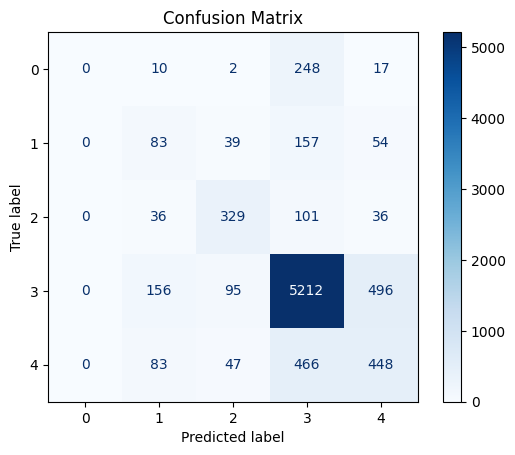


Confusion Matrix Statistics:
Total samples: 8115
Class distribution in true labels: [ 277  333  502 5959 1044]
Class distribution in predictions: [   0  368  512 6184 1051]
Number of true labels: 1344
Number of predicted labels: 1344


<Figure size 1000x800 with 0 Axes>

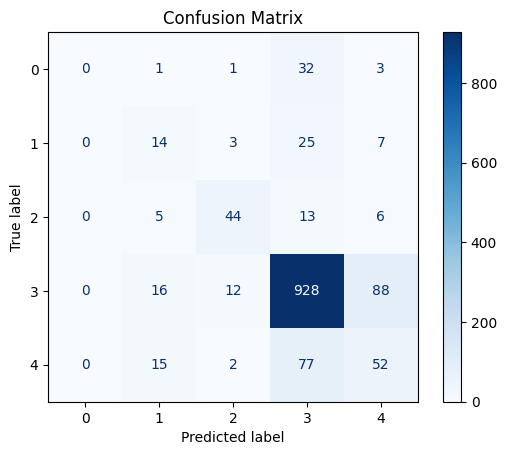


Confusion Matrix Statistics:
Total samples: 1344
Class distribution in true labels: [  37   49   68 1044  146]
Class distribution in predictions: [   0   51   62 1075  156]


In [34]:
# Assuming your dataset has 4 classes (car, truck, bike, bus)
num_classes = 5

# Assuming you have already trained the model
train_mAP, valid_mAP = evaluate_model(model, train_loader, valid_loader, num_classes, DEVICE)


In [46]:
!ls

fasterrcnn_finetuned_epoch10.pth  fasterrcnn_finetuned_epoch6.pth
fasterrcnn_finetuned_epoch1.pth   fasterrcnn_finetuned_epoch7.pth
fasterrcnn_finetuned_epoch2.pth   fasterrcnn_finetuned_epoch8.pth
fasterrcnn_finetuned_epoch3.pth   fasterrcnn_finetuned_epoch9.pth
fasterrcnn_finetuned_epoch4.pth   vehiclecollision
fasterrcnn_finetuned_epoch5.pth


In [ ]:
!cat vehiclecollision/data.yaml

In [47]:
!mkdir runs
!mv fasterrcnn_finetuned_epoch10.pth runs/
!tar -czvf runs.tar.gz runs

runs/
runs/fasterrcnn_finetuned_epoch10.pth


In [ ]:
!ls -lh


Predicted Labels:
  Class Number: 3, Class Name: Car, Confidence: 1.00
  Class Number: 3, Class Name: Car, Confidence: 1.00
  Class Number: 3, Class Name: Car, Confidence: 1.00
  Class Number: 4, Class Name: Collision, Confidence: 0.99
  Class Number: 1, Class Name: Truck, Confidence: 0.99


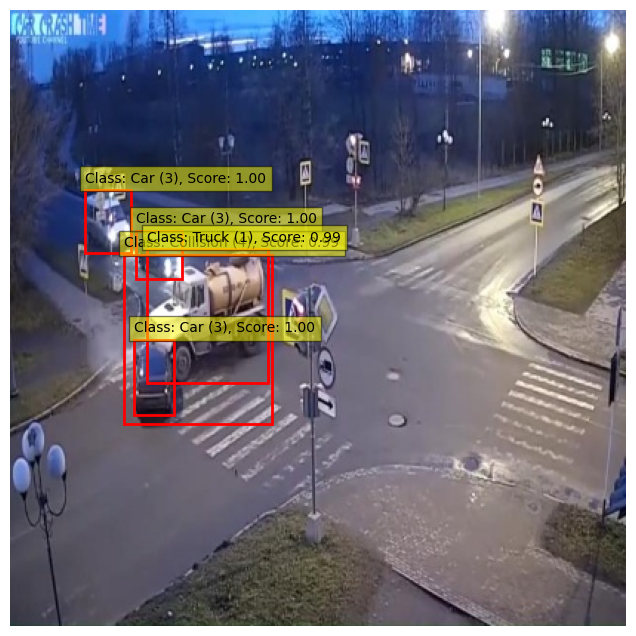


Ground Truth Labels:
  Class Number: 1, Class Name: Truck
  Class Number: 3, Class Name: Car
  Class Number: 3, Class Name: Car
  Class Number: 3, Class Name: Car

Ground Truth Boxes: [[ 92.7875 161.3625 174.3625 252.0375]
 [ 83.0375 221.975  109.3625 273.975 ]
 [ 84.0125 148.2    115.5375 181.35  ]
 [ 50.5375 121.55    81.4125 162.5   ]]


In [50]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

#names: ['Bus', 'Truck', 'Motorcycle', 'Car', 'Collision']
# Define class names mapping
CLASS_NAMES = {
    0: "Bus",
    1: "Truck",
    2: "Bike",
    3: "Car",
    4: "Collision"
}

def visualize_prediction(model, dataset, index=0, threshold=0.5):
    """
    Function to visualize model predictions on a single image from the test dataset.
    """
    model.eval()  # Set model to evaluation mode

    # Get a single image and target from the dataset
    image, target = dataset[index]  
    image_tensor = image.to(DEVICE).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        prediction = model(image_tensor)  # Get predictions

    # Extract results
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()

    # Filter predictions based on score threshold
    valid_indices = pred_scores >= threshold
    pred_boxes = pred_boxes[valid_indices]
    pred_labels = pred_labels[valid_indices]
    pred_scores = pred_scores[valid_indices]

    # Convert image tensor to numpy format for visualization
    image_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()  # Convert from tensor

    # Plot image and bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(image_np)
    ax = plt.gca()

    print("\nPredicted Labels:")
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

        class_name = CLASS_NAMES.get(label, "Unknown")
        ax.text(x_min, y_min - 5, f"Class: {class_name} ({label}), Score: {score:.2f}",
                bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

        # Print the predicted class number and name separately
        print(f"  Class Number: {label}, Class Name: {class_name}, Confidence: {score:.2f}")

    plt.axis("off")
    plt.show()

    # Print Ground Truth Labels and Boxes
    print("\nGround Truth Labels:")
    for label in target['labels'].cpu().numpy():
        class_name = CLASS_NAMES.get(label, "Unknown")
        print(f"  Class Number: {label}, Class Name: {class_name}")

    print("\nGround Truth Boxes:", target['boxes'].cpu().numpy())

# Call the function with a test dataset index
visualize_prediction(model, test_dataset, index=25, threshold=0.5)
